We will use the data curated in module 1 and the features engineered last time and try to implement four machine learning algorithms to help us with our problem statement:
1. Ridge Regression
2. Random Forest
3. XGBoost
4. Neural Networks - MultiLayer Perceptron

The general approach and outline to the problem will be similar:
1. As this is time series data where the sequence matters, we will not randomly split and shuffle the training and test dataset
2. We shall use GridSearchCV for hyperparameter turning on the training and validation dataset. 
3. We shall use the test dataset for final backtesting and comparison which we shall present in Module 3

# Rigde Regression Implementation

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Load your data
normalized_weight_vectors = pd.read_csv("normalized_weight_vectors_final.csv")  # Replace with your actual data path
cleaned_df_with_features = pd.read_csv("df_with_features_final.csv")  # Replace with your actual data path

# Add a subscript '_Wt' to the column names in normalized_weight_vectors
normalized_weight_vectors.columns = [col + '_Wt' if col != 'Date' else col for col in normalized_weight_vectors.columns]
normalized_weight_vectors.head(2)

,Date,SMB_Wt,HML_Wt,RMW_Wt,CMA_Wt,Mom _Wt
0,1990-05,0.072346,0.044390,0.266922,0.101199,0.515143
1,1990-06,0.173008,0.066401,0.124421,0.328600,0.307570


In [2]:
# Assuming you have a column 'date' in both DataFrames for merging
data = pd.merge(normalized_weight_vectors, cleaned_df_with_features, on='Date')
data.head(2)

,Date,SMB_Wt,HML_Wt,RMW_Wt,CMA_Wt,Mom _Wt,Mkt-RF,SMB,HML,RMW,...,HML_RMW_spread,HML_CMA_spread,HML_RF_spread,HML_Mom _spread,RMW_CMA_spread,RMW_RF_spread,RMW_Mom _spread,CMA_RF_spread,CMA_Mom _spread,RF_Mom _spread
0,1990-05,0.072346,0.044390,0.266922,0.101199,0.515143,1.83,1.62,-2.92,2.04,...,-4.96,-1.90,-3.56,-4.72,3.06,1.40,0.24,-1.66,-2.82,-1.16
1,1990-06,0.173008,0.066401,0.124421,0.328600,0.307570,-3.36,-0.33,-2.59,1.78,...,-4.37,-1.61,-3.28,-4.98,2.76,1.09,-0.61,-1.67,-3.37,-1.70


# data.columns

In [4]:
# Split the data into features and target
X = data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y = data[['Date', 'SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']]

# Sort the data by 'date' in ascending order
data_sorted = data.sort_values(by='Date')
data_sorted.head(5)

,Date,SMB_Wt,HML_Wt,RMW_Wt,CMA_Wt,Mom _Wt,Mkt-RF,SMB,HML,RMW,...,HML_RMW_spread,HML_CMA_spread,HML_RF_spread,HML_Mom _spread,RMW_CMA_spread,RMW_RF_spread,RMW_Mom _spread,CMA_RF_spread,CMA_Mom _spread,RF_Mom _spread
0,1990-05,0.072346,0.044390,0.266922,0.101199,0.515143,1.83,1.62,-2.92,2.04,...,-4.96,-1.90,-3.56,-4.72,3.06,1.40,0.24,-1.66,-2.82,-1.16
1,1990-06,0.173008,0.066401,0.124421,0.328600,0.307570,-3.36,-0.33,-2.59,1.78,...,-4.37,-1.61,-3.28,-4.98,2.76,1.09,-0.61,-1.67,-3.37,-1.70
2,1990-07,0.006523,0.687068,0.114511,0.066165,0.125733,8.42,-2.35,-3.83,1.57,...,-5.40,-2.15,-4.51,-6.86,3.25,0.89,-1.46,-2.36,-4.71,-2.35
3,1990-08,0.026929,0.170913,0.297757,0.308477,0.195924,-1.09,1.35,-1.93,-1.03,...,-0.90,-1.54,-2.56,-4.33,-0.64,-1.66,-3.43,-1.02,-2.79,-1.77
4,1990-09,0.025667,0.061436,0.005760,0.352296,0.554842,-1.90,-3.16,-0.03,-0.18,...,0.15,-3.24,-0.71,-6.13,-3.39,-0.86,-6.28,2.53,-2.89,-5.42


In [5]:
# Define the proportions for train, validation, and test sets
train_size = 0.6
validation_size = 0.2
test_size = 0.2

# Calculate the split points based on the sorted data
train_split = int(train_size * len(data_sorted))
validation_split = int((train_size + validation_size) * len(data_sorted))

# Split the data
train_data = data_sorted[:train_split]
validation_data = data_sorted[train_split:validation_split]
test_data = data_sorted[validation_split:]


# Extract features and target columns
X_train = train_data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y_train = train_data[['SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']]  # Skip the 'Date' column and the first column 'momentum_Wt'

X_validation = validation_data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y_validation = validation_data[['SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']] 

X_test = test_data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y_test = test_data[['SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']] 

# Hyperparameter tuning for alpha using the validation set
best_alpha = None
best_mse = float('inf')

alphas = [0.01, 0.1, 1, 10, 100]  # List of alpha values to test

for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validation)
    mse = mean_squared_error(y_validation, y_pred)
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha

# Train the final Ridge Regression model with the best alpha
final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train, y_train)

C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future

Ridge(alpha=100)

In [6]:
# Make predictions on the test set
y_pred_test = final_model.predict(X_test)

C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [7]:
# Make predictions on the test set
y_pred_test_rr = final_model.predict(X_test)

# Clip predicted values to ensure they are greater than or equal to 0
y_pred_test_rr_clipped = np.clip(y_pred_test_rr, 0, None)

# Normalize predicted values to ensure the sum is equal to 1
y_pred_test_rr_normalized = y_pred_test_rr_clipped / y_pred_test_rr_clipped.sum(axis=1, keepdims=True)

# Evaluate the model on the test set
mse_test_rr_normalized = mean_squared_error(y_test, y_pred_test_rr_normalized)
print(f"Mean Squared Error (Random Forest on Test Set - Clipped & Normalized): {mse_test_rr_normalized}")

# To access the predictions with Dates:
test_predictions_rr_normalized = pd.DataFrame({'Date': test_data['Date']})
for i, col in enumerate(y.columns[1:]):  # Skip the 'Date' column in y
    test_predictions_rr_normalized[col] = y_pred_test_rr_normalized[:, i]

test_predictions_rr_normalized


Mean Squared Error (Random Forest on Test Set - Clipped & Normalized): 0.03701727536674534


C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


,Date,SMB_Wt,HML_Wt,RMW_Wt,CMA_Wt,Mom _Wt
304,2015-09,0.205392,0.197807,0.140310,0.084999,0.371491
305,2015-10,0.222923,0.167722,0.185753,0.195429,0.228174
306,2015-11,0.219029,0.146695,0.141266,0.259281,0.233729
307,2015-12,0.164287,0.029871,0.232274,0.241345,0.332223
308,2016-01,0.111247,0.185414,0.194624,0.249700,0.259015
...,...,...,...,...,...,...
376,2021-09,0.102625,0.133352,0.152107,0.320135,0.291781
377,2021-10,0.164802,0.116346,0.122506,0.320116,0.276230
378,2021-11,0.115589,0.242404,0.201372,0.234370,0.206266
379,2021-12,0.095401,0.236318,0.241991,0.249913,0.176376


<AxesSubplot:xlabel='Date'>

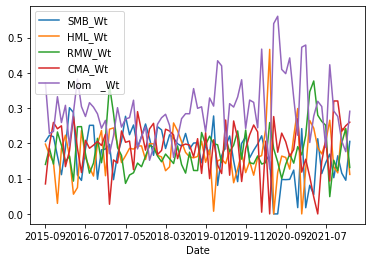

In [8]:
test_predictions_rr_normalized.set_index('Date').plot()

# Random Forest Implementation

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Load your data
normalized_weight_vectors = pd.read_csv("normalized_weight_vectors_final.csv")  # Replace with your actual data path
cleaned_df_with_features = pd.read_csv("df_with_features_final.csv")  # Replace with your actual data path

# Add a subscript '_Wt' to the column names in normalized_weight_vectors
normalized_weight_vectors.columns = [col + '_Wt' if col != 'Date' else col for col in normalized_weight_vectors.columns]

# Assuming you have a column 'Date' in both DataFrames for merging
data = pd.merge(normalized_weight_vectors, cleaned_df_with_features, on='Date')

# Split the data into features and target
X = data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y = data[['Date', 'SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']]

# Sort the data by 'Date' in ascending order
data_sorted = data.sort_values(by='Date')

# Define the proportions for train, validation, and test sets
train_size = 0.6
validation_size = 0.2
test_size = 0.2

# Calculate the split points based on the sorted data
train_split = int(train_size * len(data_sorted))
validation_split = int((train_size + validation_size) * len(data_sorted))

# Split the data
train_data = data_sorted[:train_split]
validation_data = data_sorted[train_split:validation_split]
test_data = data_sorted[validation_split:]

# Extract features and target columns
X_train = train_data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y_train = train_data[['SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']]  # Skip the 'Date' column and the first column 'momentum_Wt'

X_validation = validation_data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y_validation = validation_data[['SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']] 

X_test = test_data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y_test = test_data[['SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']] 

# Hyperparameter tuning for Random Forest on the validation set
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest model
rf_model = RandomForestRegressor()

# Create a GridSearchCV object for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Train the final Random Forest model with the best hyperparameters
final_model = RandomForestRegressor(**best_params)
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test_rf = final_model.predict(X_test)

# Clip predicted values to ensure they are greater than or equal to 0
y_pred_test_rf_clipped = np.clip(y_pred_test_rf, 0, None)

# Normalize predicted values to ensure the sum is equal to 1
y_pred_test_rf_normalized = y_pred_test_rf_clipped / y_pred_test_rf_clipped.sum(axis=1, keepdims=True)

# Evaluate the model on the test set
mse_test_rf_normalized = mean_squared_error(y_test, y_pred_test_rf_normalized)
print(f"Mean Squared Error (Random Forest on Test Set - Clipped & Normalized): {mse_test_rf_normalized}")
print(f"Best Hyperparameters: {best_params}")


# To access the predictions with Dates:
test_predictions_rf_normalized = pd.DataFrame({'Date': test_data['Date']})
for i, col in enumerate(y.columns[1:]):  # Skip the 'Date' column in y
    test_predictions_rf_normalized[col] = y_pred_test_rf_normalized[:, i]

test_predictions_rf_normalized



C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future

Mean Squared Error (Random Forest on Test Set - Clipped & Normalized): 0.03365536942047973
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}


C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


,Date,SMB_Wt,HML_Wt,RMW_Wt,CMA_Wt,Mom _Wt
304,2015-09,0.198189,0.233652,0.158639,0.193111,0.216409
305,2015-10,0.178739,0.228123,0.168303,0.192484,0.232351
306,2015-11,0.202226,0.186756,0.177000,0.212229,0.221789
307,2015-12,0.205318,0.152321,0.165762,0.231811,0.244788
308,2016-01,0.202964,0.199462,0.190786,0.194627,0.212161
...,...,...,...,...,...,...
376,2021-09,0.212304,0.177560,0.190233,0.192404,0.227499
377,2021-10,0.179381,0.210152,0.190727,0.232461,0.187279
378,2021-11,0.172393,0.179519,0.188543,0.220026,0.239519
379,2021-12,0.158319,0.228738,0.182906,0.201220,0.228817


<AxesSubplot:xlabel='Date'>

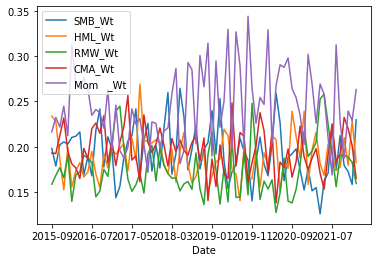

In [10]:
test_predictions_rf_normalized.set_index('Date').plot()

In [11]:
X_test

,Mkt-RF,SMB,HML,RMW,CMA,RF,Mom,Mkt-RF_lag1,SMB_lag1,HML_lag1,...,HML_RMW_spread,HML_CMA_spread,HML_RF_spread,HML_Mom _spread,RMW_CMA_spread,RMW_RF_spread,RMW_Mom _spread,CMA_RF_spread,CMA_Mom _spread,RF_Mom _spread
304,1.54,-4.55,-4.13,0.30,-2.41,0.0,9.98,-1.53,2.90,-0.79,...,-4.43,-1.72,-4.13,-14.11,2.71,0.30,-9.68,-2.41,-12.39,-9.98
305,-6.04,0.25,2.77,0.68,1.19,0.0,-2.09,1.54,-4.55,-4.13,...,2.09,1.58,2.77,4.86,-0.51,0.68,2.77,1.19,3.28,2.09
306,-3.07,-2.79,0.56,1.77,-0.58,0.0,5.22,-6.04,0.25,2.77,...,-1.21,1.14,0.56,-4.66,2.35,1.77,-3.45,-0.58,-5.80,-5.22
307,7.75,-2.07,-0.46,0.88,0.52,0.0,-3.28,-3.07,-2.79,0.56,...,-1.34,-0.98,-0.46,2.82,0.36,0.88,4.16,0.52,3.80,3.28
308,0.56,3.31,-0.42,-2.75,-0.99,0.0,2.28,7.75,-2.07,-0.46,...,2.33,0.57,-0.42,-2.70,-1.76,-2.75,-5.03,-0.99,-3.27,-2.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,1.27,-4.61,-1.78,5.46,-0.52,0.0,-2.28,2.75,-0.34,-7.87,...,-7.24,-1.26,-1.78,0.50,5.98,5.46,7.74,-0.52,1.76,2.28
377,2.91,-0.68,-0.15,-0.28,-1.79,0.0,2.45,1.27,-4.61,-1.78,...,0.13,1.64,-0.15,-2.60,1.51,-0.28,-2.73,-1.79,-4.24,-2.45
378,-4.37,1.12,5.08,-1.96,2.10,0.0,1.49,2.91,-0.68,-0.15,...,7.04,2.98,5.08,3.59,-4.06,-1.96,-3.45,2.10,0.61,-1.49
379,6.65,-2.70,-0.49,1.66,-1.45,0.0,3.19,-4.37,1.12,5.08,...,-2.15,0.96,-0.49,-3.68,3.11,1.66,-1.53,-1.45,-4.64,-3.19


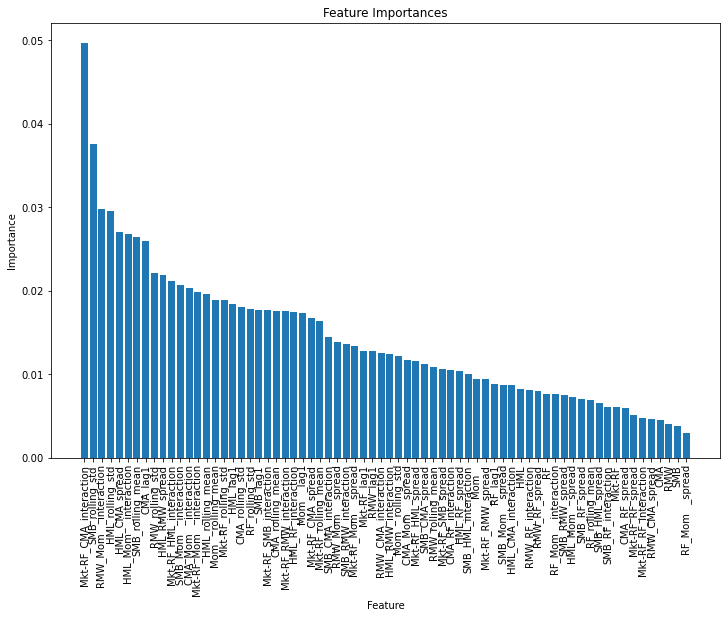

In [12]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = final_model.feature_importances_

# Get feature names from your dataset (assuming X_train is a DataFrame)
feature_names = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.title("Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

# XGBoost Implementation

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Load your data
normalized_weight_vectors = pd.read_csv("normalized_weight_vectors_final.csv")  # Replace with your actual data path
cleaned_df_with_features = pd.read_csv("df_with_features_final.csv")  # Replace with your actual data path

# Add a subscript '_Wt' to the column names in normalized_weight_vectors
normalized_weight_vectors.columns = [col + '_Wt' if col != 'Date' else col for col in normalized_weight_vectors.columns]

# Assuming you have a column 'Date' in both DataFrames for merging
data = pd.merge(normalized_weight_vectors, cleaned_df_with_features, on='Date')

# Split the data into features and target
X = data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y = data[['Date', 'SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']]

# Sort the data by 'Date' in ascending order
data_sorted = data.sort_values(by='Date')

# Define the proportions for train, validation, and test sets
train_size = 0.6
validation_size = 0.2
test_size = 0.2

# Calculate the split points based on the sorted data
train_split = int(train_size * len(data_sorted))
validation_split = int((train_size + validation_size) * len(data_sorted))

# Split the data
train_data = data_sorted[:train_split]
validation_data = data_sorted[train_split:validation_split]
test_data = data_sorted[validation_split:]


# Extract features and target columns
X_train = train_data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y_train = train_data[['SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']]  # Skip the 'Date' column and the first column 'momentum_Wt'

X_validation = validation_data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y_validation = validation_data[['SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']] 

X_test = test_data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y_test = test_data[['SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']] 


# Hyperparameter tuning for XGBoost on the validation set
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Create an XGBoost model
xgb_model = XGBRegressor()

# Create a GridSearchCV object for hyperparameter tuning
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search_xgb.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params_xgb = grid_search_xgb.best_params_

# Train the final XGBoost model with the best hyperparameters
final_model_xgb = XGBRegressor(**best_params_xgb)
final_model_xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test_xgb = final_model_xgb.predict(X_test)

# Clip predicted values to ensure they are greater than or equal to 0
y_pred_test_xgb_clipped = np.clip(y_pred_test_xgb, 0, None)

# Normalize predicted values to ensure the sum is equal to 1
y_pred_test_xgb_normalized = y_pred_test_xgb_clipped / y_pred_test_xgb_clipped.sum(axis=1, keepdims=True)

# Evaluate the model on the test set
mse_test_xgb_normalized = mean_squared_error(y_test, y_pred_test_xgb_normalized)
print(f"Mean Squared Error (XGBoost on Test Set - Clipped & Normalized): {mse_test_xgb_normalized}")

# To access the predictions with Dates:
test_predictions_xgb_normalized = pd.DataFrame({'Date': test_data['Date']})
for i, col in enumerate(y.columns[1:]):  # Skip the 'Date' column in y
    test_predictions_xgb_normalized[col] = y_pred_test_xgb_normalized[:, i]

test_predictions_xgb_normalized


# Evaluate the model on the test set
mse_test_xgb = mean_squared_error(y_test, y_pred_test_xgb)
print(f"Best Hyperparameters for XGBoost: {best_params_xgb}")
print(f"Mean Squared Error (XGBoost on Test Set): {mse_test_xgb}")

# To access the predictions with Dates:
test_predictions_xgb = pd.DataFrame({'Date': test_data['Date']})
for i, col in enumerate(y.columns[1:]):  # Skip the 'Date' column in y
    test_predictions_xgb[col] = y_pred_test_xgb[:, i]

test_predictions_xgb


Mean Squared Error (XGBoost on Test Set - Clipped & Normalized): 0.0333865714312537
Best Hyperparameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Mean Squared Error (XGBoost on Test Set): 0.03343750860954027


C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


,Date,SMB_Wt,HML_Wt,RMW_Wt,CMA_Wt,Mom _Wt
304,2015-09,0.211813,0.225201,0.166149,0.174006,0.209111
305,2015-10,0.198504,0.203535,0.193665,0.210126,0.210043
306,2015-11,0.205172,0.189049,0.163022,0.202739,0.191734
307,2015-12,0.198846,0.166455,0.169659,0.212510,0.214457
308,2016-01,0.221299,0.209699,0.197460,0.181119,0.215755
...,...,...,...,...,...,...
376,2021-09,0.222844,0.168969,0.184324,0.212713,0.199516
377,2021-10,0.210206,0.221213,0.178303,0.222222,0.201469
378,2021-11,0.184331,0.188331,0.191116,0.217197,0.208819
379,2021-12,0.184314,0.200434,0.185419,0.207926,0.218131


<AxesSubplot:xlabel='Date'>

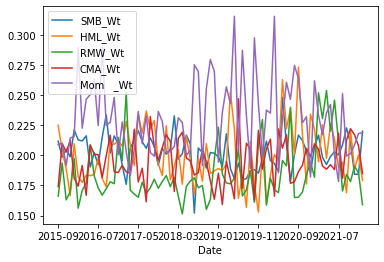

In [14]:
test_predictions_xgb.set_index('Date').plot()

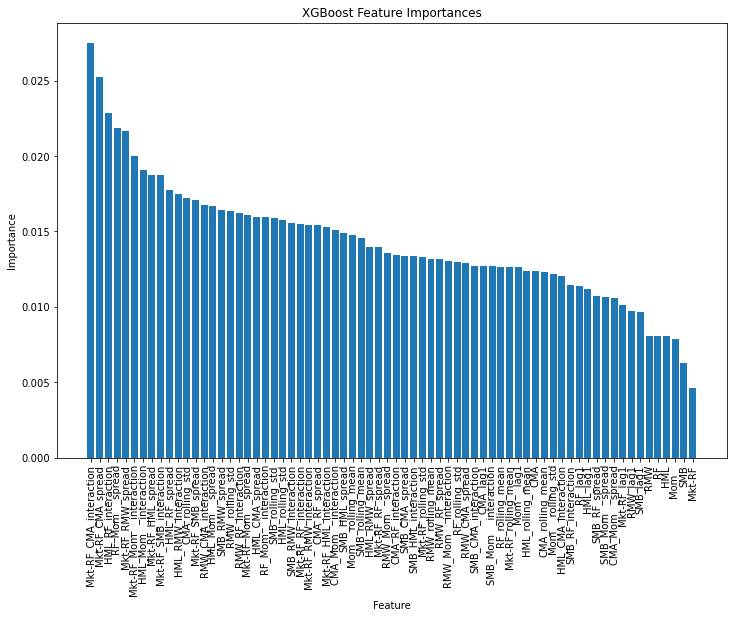

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train_xgb is the feature matrix used for XGBoost
# (you may need to adjust if a different variable name was used)

# Get feature importances from the best XGBoost model
feature_importances_xgb = final_model_xgb.feature_importances_

# Get feature names from X_train_xgb
feature_names_xgb = X_train.columns

# Sort feature importances in descending order
indices_xgb = np.argsort(feature_importances_xgb)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.bar(range(X_train.shape[1]), feature_importances_xgb[indices_xgb], align="center")
plt.xticks(range(X_train.shape[1]), feature_names_xgb[indices_xgb], rotation=90)
plt.title("XGBoost Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [16]:
# !pip install xgboost

# Neural Networks MLP Implementation

In [ ]:
test_predictions_mlp.set_index('Date').plot()

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Load your data
normalized_weight_vectors = pd.read_csv("normalized_weight_vectors_final.csv")  # Replace with your actual data path
cleaned_df_with_features = pd.read_csv("df_with_features_final.csv")  # Replace with your actual data path

# Add a subscript '_Wt' to the column names in normalized_weight_vectors
normalized_weight_vectors.columns = [col + '_Wt' if col != 'Date' else col for col in normalized_weight_vectors.columns]

# Assuming you have a column 'Date' in both DataFrames for merging
data = pd.merge(normalized_weight_vectors, cleaned_df_with_features, on='Date')

# Split the data into features and target
X = data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y = data[['Date', 'SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']]

# Sort the data by 'Date' in ascending order
data_sorted = data.sort_values(by='Date')

# Define the proportions for train, validation, and test sets
train_size = 0.6
validation_size = 0.2
test_size = 0.2

# Calculate the split points based on the sorted data
train_split = int(train_size * len(data_sorted))
validation_split = int((train_size + validation_size) * len(data_sorted))

# Split the data
train_data = data_sorted[:train_split]
validation_data = data_sorted[train_split:validation_split]
test_data = data_sorted[validation_split:]

# Extract features and target columns
X_train = train_data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y_train = train_data[['SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']]  # Skip the 'Date' column and the first column 'momentum_Wt'

X_validation = validation_data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y_validation = validation_data[['SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']] 

X_test = test_data.drop(['Date','SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt'], axis=1)
y_test = test_data[['SMB_Wt', 'HML_Wt', 'RMW_Wt', 'CMA_Wt', 'Mom   _Wt']] 

# Hyperparameter tuning for MLP on the validation set
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (50, 25, 10)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

# Create an MLPRegressor model
mlp_model = MLPRegressor(max_iter=500)

# Create a GridSearchCV object for hyperparameter tuning
grid_search_mlp = GridSearchCV(estimator=mlp_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search_mlp.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params_mlp = grid_search_mlp.best_params_

# Train the final MLP model with the best hyperparameters
final_model_mlp = MLPRegressor(max_iter=500, **best_params_mlp)
final_model_mlp.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test_mlp = final_model_mlp.predict(X_test)

# Clip predicted values to ensure they are greater than or equal to 0
y_pred_test_mlp_clipped = np.clip(y_pred_test_mlp, 0, None)

# Normalize predicted values to ensure the sum is equal to 1
y_pred_test_mlp_normalized = y_pred_test_mlp_clipped / y_pred_test_mlp_clipped.sum(axis=1, keepdims=True)

# Evaluate the model on the test set
mse_test_mlp_normalized = mean_squared_error(y_test, y_pred_test_mlp_normalized)
print(f"Mean Squared Error (MLP on Test Set - Clipped & Normalized): {mse_test_mlp_normalized}")

# To access the predictions with Dates:
test_predictions_mlp_normalized = pd.DataFrame({'Date': test_data['Date']})
for i, col in enumerate(y.columns[1:]):  # Skip the 'Date' column in y
    test_predictions_mlp_normalized[col] = y_pred_test_mlp_normalized[:, i]

test_predictions_mlp_normalized

C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future

Mean Squared Error (MLP on Test Set - Clipped & Normalized): 0.057471369004267615


C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


,Date,SMB_Wt,HML_Wt,RMW_Wt,CMA_Wt,Mom _Wt
304,2015-09,0.000000,0.118283,0.210442,0.239459,0.431816
305,2015-10,0.468673,0.206922,0.129878,0.100537,0.093990
306,2015-11,0.269326,0.342838,0.042698,0.245261,0.099877
307,2015-12,0.166873,0.078796,0.185563,0.159134,0.409635
308,2016-01,0.068361,0.000000,0.270777,0.267629,0.393234
...,...,...,...,...,...,...
376,2021-09,0.064494,0.230467,0.192735,0.382048,0.130256
377,2021-10,0.012662,0.273735,0.123671,0.073498,0.516433
378,2021-11,0.442711,0.064291,0.090067,0.402931,0.000000
379,2021-12,0.157144,0.375937,0.173769,0.184178,0.108972


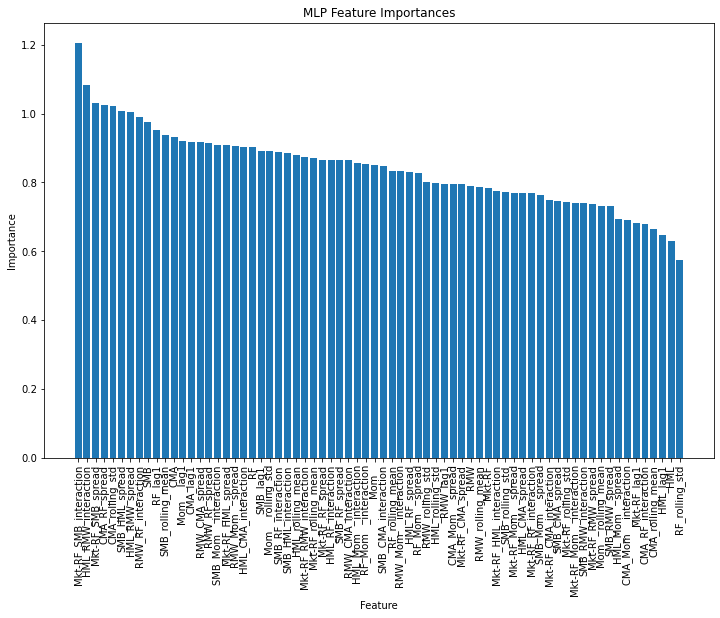

In [18]:
# Assuming final_model_mlp is the trained MLP model
# (you may need to adjust if a different variable name was used)

# Get the weights from the trained MLP model
weights_mlp = final_model_mlp.coefs_

# Calculate feature importances as the sum of squared weights for each feature
feature_importances_mlp = np.sum(np.square(weights_mlp[0]), axis=1)  # assuming the first layer is the input layer

# Get feature names from X_train (assuming X_train is a DataFrame)
feature_names_mlp = X_train.columns

# Sort feature importances in descending order
indices_mlp = np.argsort(feature_importances_mlp)[::-1]

# Plot the feature importances
plt.figure(figsize=(12 , 8))
plt.bar(range(X_train.shape[1]), feature_importances_mlp[indices_mlp], align="center")
plt.xticks(range(X_train.shape[1]), feature_names_mlp[indices_mlp], rotation=90)
plt.title("MLP Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


# Getting the final allocations

In [22]:
test_predictions_rr_normalized.to_csv('Ridge_Regression_Weights_Final.csv')

In [23]:
test_predictions_rf_normalized.to_csv('Random_Forest_Weights_Final.csv')

In [24]:
test_predictions_xgb.to_csv('XGBoost_Weights_Final.csv')

In [25]:
test_predictions_mlp_normalized.to_csv('NN_Weights_Final.csv')